### Import Libraries

In [ ]:
import numpy as np
from operator import add
from typing import Literal, Annotated, Literal, List, Optional
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

True

### States

#### Pydantic

In [46]:
class State(BaseModel):
    input_data: List[float]  # Raw numerical data
    normalized_data: Optional[List[float]] = None  # Normalized data

def normalize_node(state: State):
    """
    Simple min-max normalization node that scales data to [0,1] range
    """
    data = state.input_data
    min_val = min(data)
    max_val = max(data)
    
    # Min-max normalization
    normalized = [(x - min_val) / (max_val - min_val) for x in data]
    
    print(f"Input data: {data}")
    print(f"Normalized data: {[round(x, 3) for x in normalized]}")
    
    return {"normalized_data": normalized}

# Create the workflow
workflow = StateGraph(State)

# Add the normalization node
workflow.add_node("normalize", normalize_node)

# Define the flow
workflow.add_edge(START, "normalize")
workflow.add_edge("normalize", END)

# Compile the graph
graph = workflow.compile()

# Example usage
result = graph.invoke(
    {
        "input_data": [1, 5, 2, 8, 3]
    }
)

Input data: [1.0, 5.0, 2.0, 8.0, 3.0]
Normalized data: [0.0, 0.571, 0.143, 1.0, 0.286]


#### State Machines

In [47]:
class State(BaseModel):
    stage: Optional[Literal["📊 Data", "🎯 Training", "📈 Validation", "✅ Complete"]] = None
    continue_training: bool
    messages: Annotated[List[str], add] = []
    epoch: Annotated[int, add] = 0
    current_loss: float = float('inf')

def prepare_data(state: State):
    stage = "📊 Data"
    message = f"{stage}: Preparing training and validation splits..."
    messages = [message]
    # Simulate data preparation
    return {
        "stage": stage, 
        "messages": messages, 
        "epoch": 1
    }

def train_model(state: State):
    stage = "🎯 Training"
    epoch = state.epoch
    # Simulate training loss
    current_loss = 1.0 / (epoch + np.random.random())
    
    message = f"{stage}: Epoch {epoch} - Training Loss: {current_loss:.4f}"
    messages = [message]
    
    return {
        "stage": stage, 
        "messages": messages,
        "current_loss": current_loss,
        "epoch": epoch + 1  # Increment epoch counter
    }

def validate_model(state: State):
    stage = "📈 Validation"
    current_loss = state.current_loss
    continue_training = state.continue_training
    
    messages = []
    
    if not continue_training:
        message = f"{stage}: Validation Loss: {current_loss:.4f}"
        messages.append(message)
    else:
        if state.epoch >= 10:
            messages.append("🔚 Maximum epochs (10) reached")
            messages.append("Setting continue_training to False")
            continue_training = False
    
    messages.append("----------------------------------------------------")
    
    return {
        "stage": stage, 
        "messages": messages,
        "continue_training": continue_training,
        "current_loss": current_loss
    }

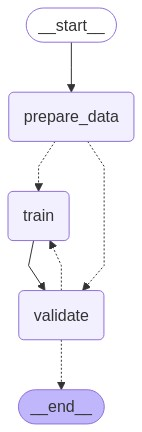

In [48]:
# Create the workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("prepare_data", prepare_data)
workflow.add_node("train", train_model)
workflow.add_node("validate", validate_model)

# Add basic flow from START to prepare_data
workflow.add_edge(START, "prepare_data")

# Add conditional check after data preparation
def should_start_training(state: State):
    if not state.continue_training:
        return "validate"
    return "train"

workflow.add_conditional_edges(
    source="prepare_data",
    path=should_start_training,
    path_map=["train", "validate"]
)

# Add edges from train to validate
workflow.add_edge("train", "validate")

# Add conditional check after validation
def should_continue_training(state: State):
    if not state.continue_training:  # Check the continue_training flag
        return END
    return "train"

workflow.add_conditional_edges(
    source="validate",
    path=should_continue_training,
    path_map=["train", END]
)

# Compile the graph
graph = workflow.compile()

# Display the workflow graph
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [49]:
# Example usage with different initial conditions
print("🤖 ------------ ML TRAINING CONTROLLER ------------🤖")
print("\nCase 1: Normal Training Run")
result = graph.invoke({"continue_training": True})
for message in result['messages']:
    print(message)

print("\nCase 2: Training Disabled")
result = graph.invoke({"continue_training": False})
for message in result['messages']:
    print(message)

🤖 ------------ ML TRAINING CONTROLLER ------------🤖

Case 1: Normal Training Run
📊 Data: Preparing training and validation splits...
🎯 Training: Epoch 1 - Training Loss: 0.5795
----------------------------------------------------
🎯 Training: Epoch 3 - Training Loss: 0.2915
----------------------------------------------------
🎯 Training: Epoch 7 - Training Loss: 0.1339
🔚 Maximum epochs (10) reached
Setting continue_training to False
----------------------------------------------------

Case 2: Training Disabled
📊 Data: Preparing training and validation splits...
📈 Validation: Validation Loss: inf
----------------------------------------------------
